# CSE 578 Final Project

## Team members:
* Rosty Hnatyshyn 
* Kyle Gonzalez 
* Nicholas Seah 
* Sang-Hun Sim 
* Arvind Hasti 
* Chandana Tarur Veerabhadraiah

## Reading the data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [4]:
# Reading data:
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                'martial-status', 'occupation', 'relationship', 'race',
                'sex', 'capital-gain', 'capital-loss', 'hours-per-week',
                'native-country', 'label']

train_df = pd.read_csv('adult.data',names = column_names,index_col = False, skipinitialspace=True)
test_df = pd.read_csv('adult.test',names = column_names,index_col = False, skiprows = 1, skipinitialspace=True)

## Cleaning the data

In [5]:
# education num is a label encoding, we want to do one-hot so we drop education-num

train_df = train_df.drop('education-num', axis='columns')
test_df = test_df.drop('education-num', axis='columns')

# drop all rows with unknown values
def clear_unknown_rows(df):
    df = df.replace('?',np.NaN)
    # existed in test but not training set, can do this in a better way but skipping for now
    df = df.replace('Holand-Netherlands', np.NaN)
    df = df.dropna()
    return df

train_df = clear_unknown_rows(train_df)
test_df = clear_unknown_rows(test_df)

# make a combined dataframe for later visualizations
combined_df = pd.concat([test_df,train_df])
combined_df.replace({'<=50K.': '<=50K', '>50K.' : '>50K', '<=50K': '<=50K', '>50K' : '>50K'}, inplace=True)

### Cleaning the data: one hot encoding for machine learning

In [6]:
# one hot encoding - added prefix to columns so that we can consolidate them later
def encode_categories(df):
    df = df.join(pd.get_dummies(df.pop('workclass'), prefix='workclass'))
    df = df.join(pd.get_dummies(df.pop('education'), prefix='education'))
    df = df.join(pd.get_dummies(df.pop('martial-status'), prefix='martial-status'))
    df = df.join(pd.get_dummies(df.pop('occupation'), prefix='occupation'))
    df = df.join(pd.get_dummies(df.pop('relationship'), prefix='relationship'))
    df = df.join(pd.get_dummies(df.pop('race'), prefix='race' ))
    df = df.join(pd.get_dummies(df.pop('sex'), prefix='sex'))
    df = df.join(pd.get_dummies(df.pop('native-country'), prefix='native-country'))
    # label needs to be one column instead of two
    # need 4 because there's one with a period and one without
    df.replace({'<=50K.': 0, '>50K.' : 1, '<=50K': 0, '>50K' : 1}, inplace=True)
    return df

numerical_df = train_df.copy()
numerical_df.replace({'<=50K': 0, '>50K' : 1}, inplace=True)

train_df = encode_categories(train_df)
test_df = encode_categories(test_df)

In [7]:
# last step is to get the labels from the training set
train_labels_df = train_df['label']
test_labels_df = test_df['label']
train_df = train_df.drop(['label'],axis=1)
test_df = test_df.drop(['label'],axis=1)

## Building the model and running a classification task

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

clf=RandomForestClassifier(n_estimators=250,max_depth=8)
clf.fit(train_df,train_labels_df)
y_pred=clf.predict(test_df)

print("Accuracy:", metrics.accuracy_score(test_labels_df,y_pred))

Accuracy: 0.850929614873838


## Retrieving the most important features according to the model

In [9]:
feature_imp = pd.Series(clf.feature_importances_,index=train_df.columns).sort_values(ascending=False)

In [10]:
# importance = clf.feature_importances_
# names = train_df.columns
# model_type = 'Random Forest'
# Importance is feature importance values
# Names is Column names
# model_type is a string describing the model
# topfeatures is the top number features you want to plt
def plot_feature_importance(importance, names, model_type, topfeatures, encoded_categories):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data = {'feature_name': feature_names, 'feature_importance': feature_importance}
        
    FI_df = pd.DataFrame(data)
    for category in encoded_categories:
        this_category = FI_df.loc[FI_df['feature_name'].str.startswith(category)]
        this_category_importance = this_category['feature_importance'].sum(axis=0)
        FI_df = FI_df[~FI_df.feature_name.isin(this_category.feature_name)]
        FI_df = FI_df.append({'feature_name': category, 'feature_importance': this_category_importance}, ignore_index=True)
    
    # Sort DF in terms of feature importance
    FI_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
    
    # Font 
    font = {'fontname': 'Georgia'}
    
    
    
    #Plot Feature Importance Bar Chart
    plt.figure(figsize = (5,5))
    sns.barplot(x = FI_df['feature_importance'][:topfeatures], y = FI_df['feature_name'][:topfeatures])
    # Add chart labels
#     for index, value in enumerate(feature_importance[:topfeatures]):
#         plt.text(value + 0.01, index, str(value), color = 'black', **font)
    
    plt.title(model_type + ' Feature Importance',**font,fontsize = 20,fontweight="bold")
    plt.xlabel('Feature Importance',**font,fontsize = 15,fontweight="bold")
    plt.ylabel('Feature Names',**font,fontsize = 15,fontweight="bold")
    plt.xticks(**font)
    plt.yticks(**font)

## Feature Importance Chart

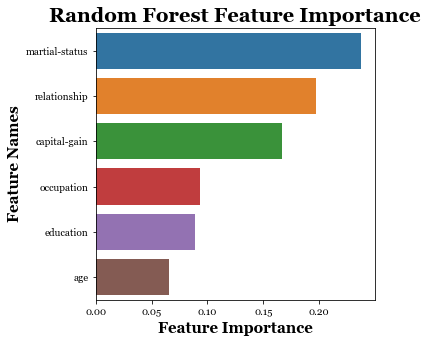

In [11]:
encoded_categories = ('workclass', 'education', 'martial-status', 'occupation', 'relationship',
                      'race', 'sex', 'native-country')
plot_feature_importance(clf.feature_importances_, train_df.columns, 'Random Forest', 6, encoded_categories)

## Dataset Analysis: Parallel Set

In [13]:
combined_df.head()

age  workclass  fnlwgt     education      martial-status  \
0   25    Private  226802          11th       Never-married   
1   38    Private   89814       HS-grad  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm  Married-civ-spouse   
3   44    Private  160323  Some-college  Married-civ-spouse   
5   34    Private  198693          10th       Never-married   

          occupation   relationship   race   sex  capital-gain  capital-loss  \
0  Machine-op-inspct      Own-child  Black  Male             0             0   
1    Farming-fishing        Husband  White  Male             0             0   
2    Protective-serv        Husband  White  Male             0             0   
3  Machine-op-inspct        Husband  Black  Male          7688             0   
5      Other-service  Not-in-family  White  Male             0             0   

   hours-per-week native-country  label  age_binned  
0              40  United-States  <=50K          25  
1              50  United-States  <=50K          38  
2              40  United-States   >50K          28  
3              40  United-States   >50K          44  
5              30  United-States  <=50K          34

In [21]:
# Parallel Set
# Will only run with plotly installed
# Beware! Resource intensive!

import plotly.graph_objects as go
import pandas as pd
numerical_df['age_binned'] = numerical_df['age']
binned_age = []
for row in numerical_df['age_binned']:
    if (row >= 10) and (row < 20):
        row = 10
        binned_age.append(row)
    if (row >= 20) and (row < 30):
        row = 20
        binned_age.append(row)
    if (row >= 30) and (row < 40):
        row = 30
        binned_age.append(row)
    if (row >= 40) and (row < 50):
        row = 40
        binned_age.append(row)
    if (row >= 50) and (row < 60):
        row = 50
        binned_age.append(row)
    if (row >= 60) and (row < 70):
        row = 60
        binned_age.append(row)
    if (row >= 70) and (row < 80):
        row = 70
        binned_age.append(row)
    if (row >= 80) and (row < 90):
        row = 80
        binned_age.append(row)
    if (row >= 90) and (row < 100):
        row = 90
        binned_age.append(row)

capital_binned = []
for row in numerical_df['capital-gain']:
    if (row>=0) and (row<2000):
        tmp = "~2000"
        capital_binned.append(tmp)
    if (row>=2000) and (row<4000):
        tmp = "2000~4000"
        capital_binned.append(tmp)
    if (row>=4000) and (row<6000):
        tmp = "4000~6000"
        capital_binned.append(tmp)
    if (row>=6000) and (row<8000):
        tmp = "6000~8000"
        capital_binned.append(tmp)
    if (row>=8000) and (row<10000):
        tmp = "8000~10000"
        capital_binned.append(tmp)
    if (row>=10000) and (row<12000):
        tmp = "10000~12000"
        capital_binned.append(tmp)
    if (row>=12000) and (row<14000):
        tmp = "12000~14000"
        capital_binned.append(tmp)
    if (row>=14000) and (row<16000):
        tmp = "14000~16000"
        capital_binned.append(tmp)
    if (row>=16000) and (row<18000):
        tmp = "16000~18000"
        capital_binned.append(tmp)
    if (row>=18000) and (row<20000):
        tmp = "18000~20000"       
        capital_binned.append(tmp)
    if (row>=20000) and (row<80000):
        tmp = "20000~80000"       
        capital_binned.append(tmp)
    if (row>=80000):
        tmp = "20000~100000"       
        capital_binned.append(tmp) 
import plotly.graph_objects as go
import pandas as pd

education_dim = go.parcats.Dimension(
    values=numerical_df["education"],label="Education",
    categoryorder='category descending')
occupation_dim = go.parcats.Dimension(values=numerical_df.occupation, label="Occupation")

age_dim = go.parcats.Dimension(values=binned_age, label='Age',
                                categoryorder='category descending')

capital_dim = go.parcats.Dimension(values=capital_binned, label='Capital-gain',
                                categoryorder='category ascending')

relationship_dim = go.parcats.Dimension(values=numerical_df.relationship, label="Relation")

martial_dim = go.parcats.Dimension(values=numerical_df["martial-status"], label="marital")

gender_dim = go.parcats.Dimension(values=numerical_df.sex, label="Gender")

label_dim = go.parcats.Dimension(
    values=numerical_df.label, categoryarray=[0, 1], label="Salary",
    ticktext=[' <=50K', ' >50K'])

color = numerical_df.label;
colorscale = [[0, 'lightsteelblue'], [1, 'red']];

fig = go.Figure(data = [go.Parcats(dimensions=[education_dim, occupation_dim, age_dim, capital_dim, martial_dim, relationship_dim, label_dim],
               line={'color': color, 'colorscale': colorscale})])
fig.update_layout(width=990, height=870)
fig.update_layout(font_size=13, font_color='black')
fig.show()

## Martial Status Mosaic Plot

In [ ]:
from statsmodels.graphics.mosaicplot import mosaic
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(18,10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
mosaic(combined_df, ['martial-status', 'label'], ax=axes, axes_label=False)
plt.show()

## Relationship Status Mosaic Plot

In [ ]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(18,10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
mosaic(combined_df, ['relationship', 'label'], ax=axes, axes_label=False)
plt.show()

## Capital Gain Chart

In [ ]:
cg_series = numerical_df['capital-gain']
salary_series = numerical_df['label']
CG_salary_df = pd.concat([cg_series,salary_series], axis = 1)

# Capital Gain Series
x = CG_salary_df['capital-gain']

# Series of capital gains equal to zero and 50k+ salary
zero_cg_50k_df = CG_salary_df[(CG_salary_df['capital-gain'] == 0) & (CG_salary_df['label'] == 1)]
zero_cg_50k_series =  zero_cg_50k_df['capital-gain']


# Series of capital gains equal to zero and no 50k+ salary
zero_cg_no50k_df = CG_salary_df[(CG_salary_df['capital-gain'] == 0) & (CG_salary_df['label'] == 0)]
zero_cg_no50k_series = zero_cg_no50k_df['capital-gain']

# Series of capital gains where they earn 50k+
nonzero_cg_50k_df = CG_salary_df[(CG_salary_df['capital-gain'] != 0) & (CG_salary_df['label'] == 1)]
nonzero_cg_50k_series = nonzero_cg_50k_df['capital-gain']

# Series of capital gains where they don't earn 50k+
nonzero_cg_no50k_df = CG_salary_df[(CG_salary_df['capital-gain'] != 0) & (CG_salary_df['label'] == 0)]
nonzero_cg_no50k_series = nonzero_cg_no50k_df['capital-gain']

plt.style.use('ggplot')


x = CG_salary_df['capital-gain']

total_non_zero_cg = len(nonzero_cg_50k_series) + len(nonzero_cg_no50k_series)
total_zero_cg = len(zero_cg_50k_series) + len(zero_cg_no50k_series)


zero_cg_counts = len(zero_cg_50k_series)
nonzero_cg_counts = len(nonzero_cg_50k_series)                   

y1 = [zero_cg_counts,nonzero_cg_counts]
y2 = [total_zero_cg - zero_cg_counts ,total_non_zero_cg - nonzero_cg_counts]

xlabels = ['Zero','Non-Zero']

plt.figure(figsize = (10,10))
plt.bar(xlabels, y1,ec = 'k')
plt.bar(xlabels, y2, bottom = y1,ec = 'k')
plt.legend(['% with 50k+ Salary','Total'])
plt.title('Capital Gain Percentage of 50k+ Salary ',fontsize = 15, fontweight = 'bold')
plt.ylabel('Frequency',fontsize = 15, fontweight = 'bold')
plt.xlabel('Capital Gain',fontsize = 15, fontweight = 'bold')

plt.show()

## Occupation Mosaic Plot

In [ ]:
plt.close()
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(18,10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
mosaic(combined_df, ['occupation', 'label'], ax=axes, axes_label=False)
plt.show()

## Education Mosaic Plot

In [ ]:
plt.close()
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(18,10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
mosaic(combined_df, ['education', 'label'], ax=axes, axes_label=False)
plt.show()

## Age Chart

In [ ]:
def stacked_bar_f(column):
    x = numerical_df[column]

    x1 = x[numerical_df['label']==1]
    #x2 = x[Age_Label_df['label']==0]

    label1 = ['Total People in' + column + 'Group']
    label2 = ['Percentage with $50K+ Salary']

    plt.figure()
    plt.hist(x , bins = 7 ,rwidth = 0.7 , stacked = True, ec = 'k',label = label1)
    plt.hist(x1 ,bins = 7, rwidth = 0.7, stacked = True, ec = 'k',label = label2)
    
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title( column +'vs Income')
    plt.legend()
    return plt.show()

In [ ]:
Feature_Series= numerical_df['age']
Label_Series = numerical_df['label']

Age_Label_df = pd.concat([Feature_Series,Label_Series], axis = 1)

x = Age_Label_df['age']

x1 = x[Age_Label_df['label']==1]
x2 = x[Age_Label_df['label']==0]

label1 = ['Total People in Age Group']
label2 = ['Percentage with $50K+ Salary']

plt.figure()
plt.hist(x , bins = 7 ,rwidth = 0.7 , stacked = True, ec = 'k',label = label1)
plt.hist(x1 ,bins = 7, rwidth = 0.7, stacked = True, ec = 'k',label = label2)


plt.xlabel('age')
plt.ylabel('Frequency')
plt.title('Age vs Income')
plt.legend()